# Introduction

With political and economic turmoil continuing to overwhelm Venezuelan society, thousands of citizens are looking to leave the country in search of new opportunities abroad, including my family currently located in Maracaibo, Venezuela. As long-time restauranteurs, they hope to settle in a “friendly” city or region where they can both integrate themselves into the American way-of-life while also maintaining connections with their native culture and family networks. They have chosen New York City as their top choice (timing dependent on multiple factors, including the current health crises and availability of visas).

This final project is intended to provide information relevant to a search for the “best” neighborhoods within New York City for a new Venezuelan restaurant. Based on previous experience and advise from friends and industry colleagues, they are looking for neighborhoods already accepting of similar culinary tastes, with an established network of suppliers relevant to Venezuelan cuisine, but without significant competition in this niche market. 

In short, where in New York City is caribbean food already popular, but without a Venezuelan restaurant?

# Data

In order to answer the above questions, data on New York City boroughs and neighborhoods (and their corresponding latitudes and longitudes) will be accessed via the following resources: https://cocl.us/new_york_dataset

New York City data relating to restaurant facilities, including cuisine-type, names, and locations will be obtained via the FourSquare API as accomplished in the previous labs.

Note: Venezuelan cuisine is a blend of multiple flavors and is not easily categorized. In Foursquare, data on Venezuelan restaurants is limited. This is due both to the limited number of true-Venezuelan restaurants in NYC, but also due to categorization challenges (Venezuelan restaurants could also fall into other categories like South American and Caribbean). In this particular case, because our menu tends to compare most favorably with Caribbean cuisine, we will focus on this category for analysis.

# Methodology

•	New York City data will be taken from https://cocl.us/new_york_dataset, organized, and processed in Pandas dataframes.

•	Foursquare will be used to access current restaurant data, including restaurant names, cuisine type, and locations.

•	Data will be organized by boroughs and then neighborhoods in order to narrow our search for the best locations to enter the market within New York City.

•	We will utilize graphs to assist in visualizing the data (Matplotlib).

Load libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium # map rendering library

from bs4 import BeautifulSoup
import os

print('Libraries imported.')

     |████████████████████████████████| 102kB 16.3MB/s ta 0:00:01
Libraries imported.


Loading functions to be used throughout the process

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # Foursquare ID
    CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' 
    CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

Confirming borough and neighborhood data loaded successfully

In [6]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


# Analysis/Discussion

In [7]:
new_york_data.shape

(306, 4)

New York City (across all five boroughs) has 306 areas designated as neighborhoods.

Let's now determine how many caribbean restaurants exist in NYC.

In [12]:
# prepare neighborhood list that contains caribbean restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
caribbean_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    caribbean_restaurants=venues[venues['Category']=='Caribbean Restaurant']   
    print('(',count,'/',len(new_york_data),')','Caribbean Restaurants in '+Neighborhood+', '+Borough+':'+str(len(caribbean_restaurants)))
    for restaurant_detail in caribbean_restaurants.values.tolist():
        id, name , category=restaurant_detail
        caribbean_rest_ny = caribbean_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Caribbean Restaurants in Wakefield, Bronx:3
done
( 2 / 306 ) Caribbean Restaurants in Co-op City, Bronx:2
done
( 3 / 306 ) Caribbean Restaurants in Eastchester, Bronx:5
done
( 4 / 306 ) Caribbean Restaurants in Fieldston, Bronx:0
done
( 5 / 306 ) Caribbean Restaurants in Riverdale, Bronx:0
done
( 6 / 306 ) Caribbean Restaurants in Kingsbridge, Bronx:1
done
( 7 / 306 ) Caribbean Restaurants in Marble Hill, Manhattan:1
done
( 8 / 306 ) Caribbean Restaurants in Woodlawn, Bronx:2
done
( 9 / 306 ) Caribbean Restaurants in Norwood, Bronx:2
done
( 10 / 306 ) Caribbean Restaurants in Williamsbridge, Bronx:8
done
( 11 / 306 ) Caribbean Restaurants in Baychester, Bronx:1
done
( 12 / 306 ) Caribbean Restaurants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Caribbean Restaurants in City Island, Bronx:0
done
( 14 / 306 ) Caribbean Restaurants in Bedford Park, Bronx:1
done
( 15 / 306 ) Caribbean Restaurants in University Heights, Bronx:0
done
( 16 / 306 ) Caribbean Restaurants in Mor

In [13]:
caribbean_rest_ny.shape

(240, 4)

Using Foursquare data, we have found 240 restaurants, across all boroughs, tagged as caribbean. 

In [14]:
caribbean_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4d375ce799fe8eec99fd2355,Ripe Kitchen & Bar
1,Bronx,Wakefield,4c9e50e38afca09379b2ff15,Ali's Roti Shop
2,Bronx,Wakefield,4c10f6aece57c92804a682d2,Jackie's West Indian Bakery
3,Bronx,Co-op City,4baab2b0f964a520c7803ae3,Country Thyme Cuisine
4,Bronx,Co-op City,4c757642b474a1cd2858b9bf,Golden Krust Caribbean Restaurant


In which boroughs are all these restaurants? Are some boroughs more "friendly" to caribbean restaurants than others?

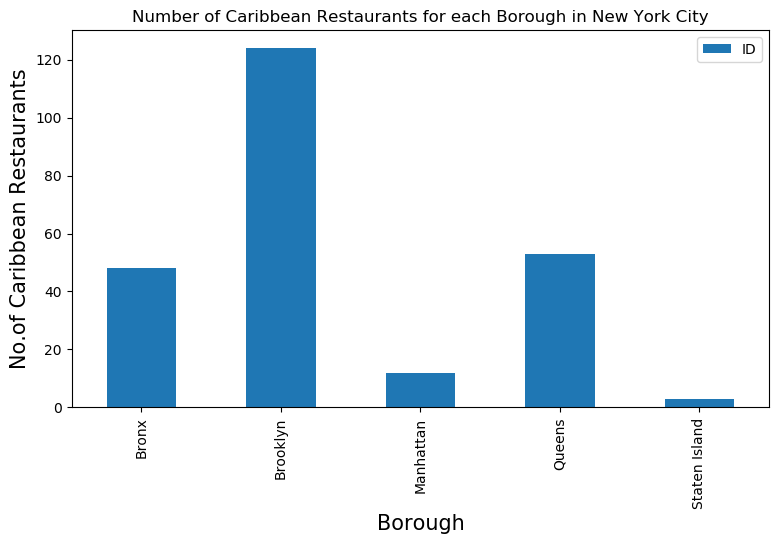

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Caribbean Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Caribbean Restaurants', fontsize=15)
#giving a bar plot
caribbean_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Wow! Brooklyn is home to many more caribbean-themed restaurants than the other boroughs. It's likely due to immigration patterns.

Let's quickly look at which neighborhoods within NYC have the most caribbean restaurants.

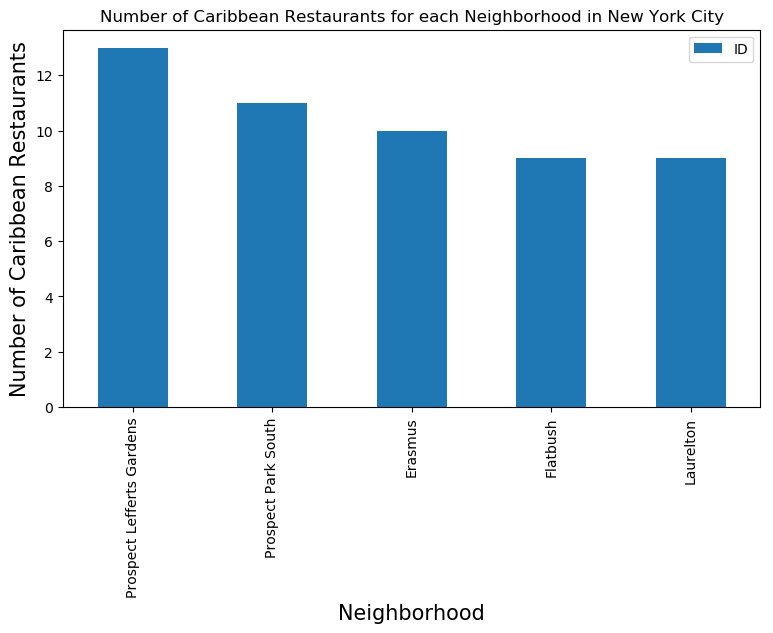

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Caribbean Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Number of Caribbean Restaurants', fontsize=15)
#giving a bar plot
caribbean_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Brooklyn continues to dominate the data. The Top 5 neighborhoods for caribbean cuisine all fall within Brooklyn.

It's clear we should be looking at Brooklyn for our new restaurant, given the infrastructure already in place to support our cuisine and the enthusiasm the local market already has for caribbean food. Let's drill down to the neighborhood level now to see if there are particular neighborhoods within Brooklyn to consider.

In [17]:
caribbean_rest_ny[caribbean_rest_ny['Borough']=='Brooklyn']

,Borough,Neighborhood,ID,Name
43,Brooklyn,Flatbush,52b27c86498e50d126766a68,Footprints Cafe Express
44,Brooklyn,Flatbush,5879815625911e1bb23364a0,Sip unWINE
45,Brooklyn,Flatbush,54fa4b21498e671122cb4d11,Island Burger
46,Brooklyn,Flatbush,4be5ad3a2457a5932fd0ab15,Fisherman's Cove
47,Brooklyn,Flatbush,4ce6e9808ef78cfaf09b8f9b,Faye & King's
48,Brooklyn,Flatbush,4ce0265e78ddf04df9b3a498,Bake & Things
49,Brooklyn,Flatbush,4bf6df9d4a67c928b49422cf,Golden Krust Caribbean Bakery & Grill
50,Brooklyn,Flatbush,4f5fcf3de4b0c27826e6c490,Exquisite Restaurant
51,Brooklyn,Flatbush,4e29ba65e4cd6c6cb3544891,McBean's Restaurant
52,Brooklyn,Crown Heights,4ad1577ff964a52020de20e3,Gloria's Caribbean Cuisine


Create a dataframe on Brooklyn for continued analysis.

In [18]:
brooklyn_rest_ny = caribbean_rest_ny[caribbean_rest_ny['Borough']=='Brooklyn']
brooklyn_rest_ny

,Borough,Neighborhood,ID,Name
43,Brooklyn,Flatbush,52b27c86498e50d126766a68,Footprints Cafe Express
44,Brooklyn,Flatbush,5879815625911e1bb23364a0,Sip unWINE
45,Brooklyn,Flatbush,54fa4b21498e671122cb4d11,Island Burger
46,Brooklyn,Flatbush,4be5ad3a2457a5932fd0ab15,Fisherman's Cove
47,Brooklyn,Flatbush,4ce6e9808ef78cfaf09b8f9b,Faye & King's
48,Brooklyn,Flatbush,4ce0265e78ddf04df9b3a498,Bake & Things
49,Brooklyn,Flatbush,4bf6df9d4a67c928b49422cf,Golden Krust Caribbean Bakery & Grill
50,Brooklyn,Flatbush,4f5fcf3de4b0c27826e6c490,Exquisite Restaurant
51,Brooklyn,Flatbush,4e29ba65e4cd6c6cb3544891,McBean's Restaurant
52,Brooklyn,Crown Heights,4ad1577ff964a52020de20e3,Gloria's Caribbean Cuisine


In [19]:
brooklyn_rest_ny.shape

(124, 4)

There are 124 caribbean restaurants just in the borough of Brooklyn.

Which neighborhoods are the most popular for caribbean food? Which the least?

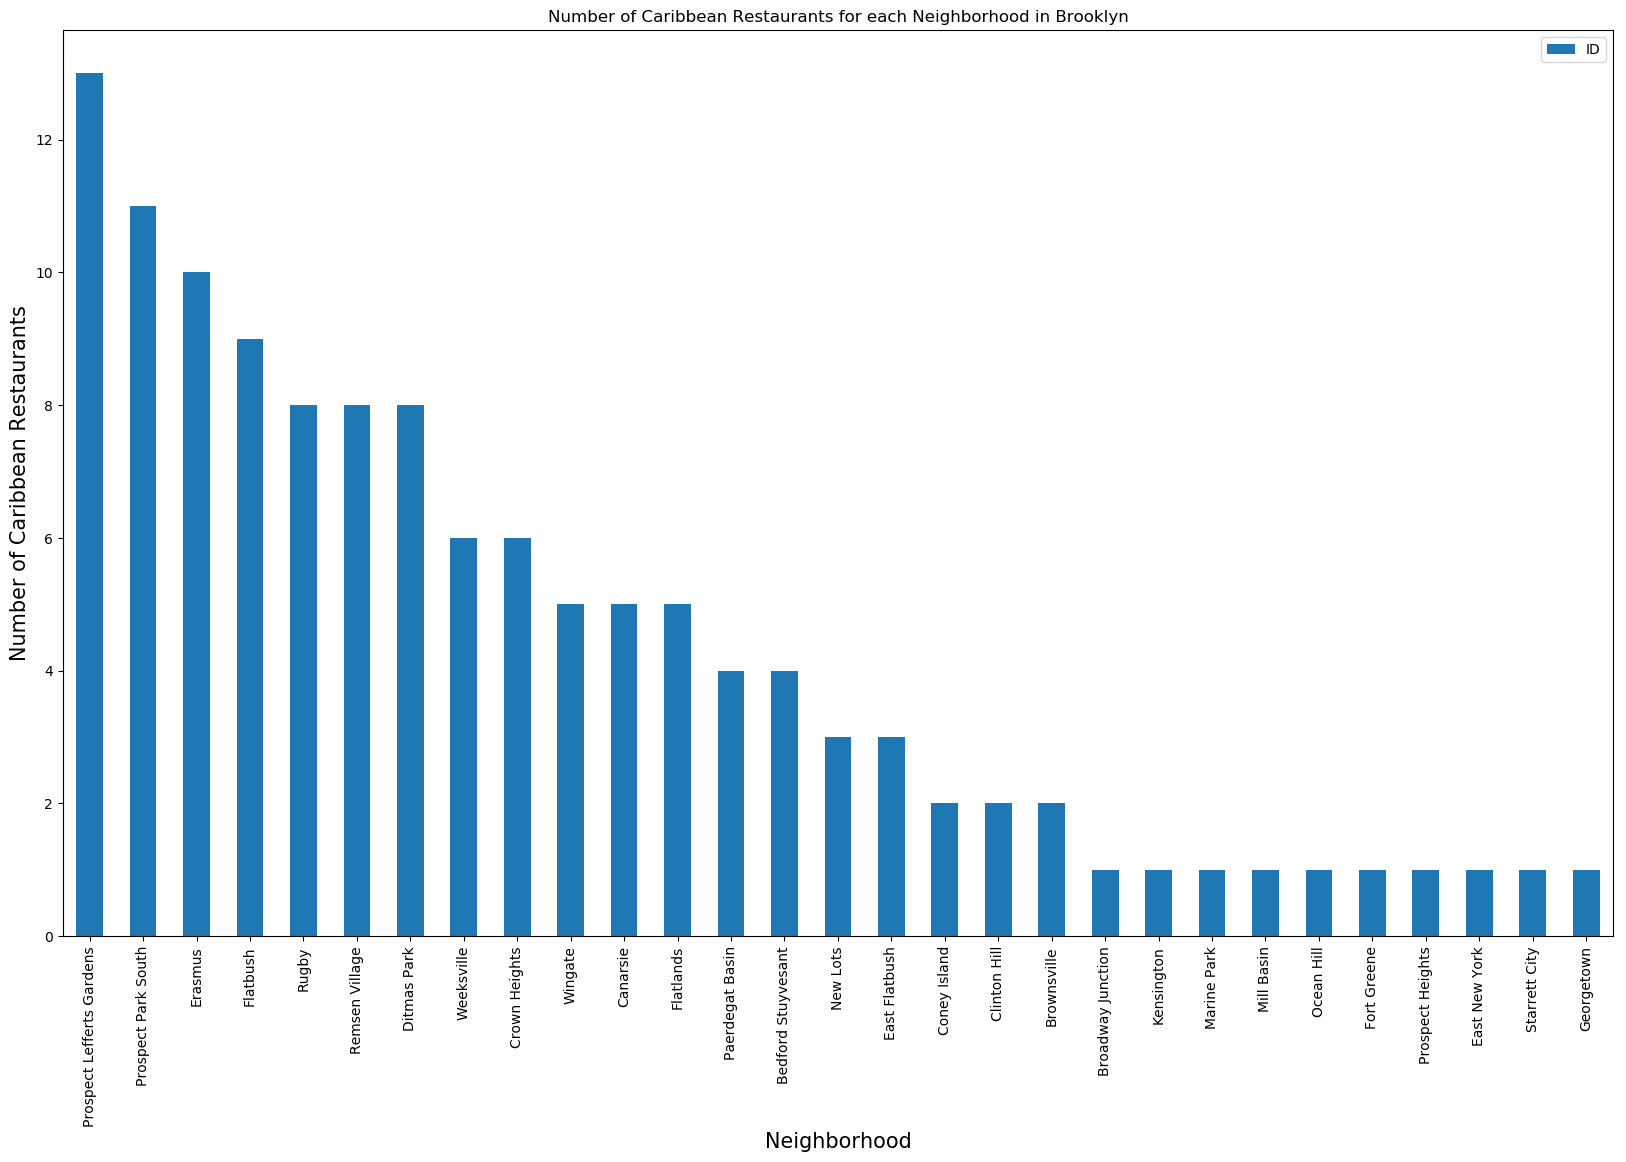

In [20]:
plt.figure(figsize=(20,12), dpi = 100)
# title
plt.title('Number of Caribbean Restaurants for each Neighborhood in Brooklyn')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Number of Caribbean Restaurants', fontsize=15)
#giving a bar plot
brooklyn_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(45).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

So there are 124 caribbean restaurants spread across all the neighborhoods of Brooklyn. But there seems to be many neighborhoods not represented here. Is Foursquare missing data? Let's see how many neighborhoods are located in Brooklyn.

In [22]:
brooklyn_data = new_york_data[new_york_data['Borough']=='Brooklyn']
brooklyn_data

,Borough,Neighborhood,Latitude,Longitude
46,Brooklyn,Bay Ridge,40.625801,-74.030621
47,Brooklyn,Bensonhurst,40.611009,-73.995180
48,Brooklyn,Sunset Park,40.645103,-74.010316
49,Brooklyn,Greenpoint,40.730201,-73.954241
50,Brooklyn,Gravesend,40.595260,-73.973471
51,Brooklyn,Brighton Beach,40.576825,-73.965094
52,Brooklyn,Sheepshead Bay,40.586890,-73.943186
53,Brooklyn,Manhattan Terrace,40.614433,-73.957438
54,Brooklyn,Flatbush,40.636326,-73.958401
55,Brooklyn,Crown Heights,40.670829,-73.943291


In [23]:
brooklyn_data.shape

(70, 4)

Ah ha! There are 70 different neighborhoods within Brooklyn and many neighborhoods are without any caribbean restaurants. Popular and trendy neighborhoods like Dumbo and Williamsburg don't appear on our restaurant list because the result is zero. But that's okay because we want to be near other caribbean restaurants.

So let's see how many restaurants are in the various neighborhoods.

In [25]:
brooklyn_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(45)

Neighborhood
Prospect Lefferts Gardens    13
Prospect Park South          11
Erasmus                      10
Flatbush                      9
Rugby                         8
Remsen Village                8
Ditmas Park                   8
Weeksville                    6
Crown Heights                 6
Wingate                       5
Canarsie                      5
Flatlands                     5
Paerdegat Basin               4
Bedford Stuyvesant            4
New Lots                      3
East Flatbush                 3
Coney Island                  2
Clinton Hill                  2
Brownsville                   2
Broadway Junction             1
Kensington                    1
Marine Park                   1
Mill Basin                    1
Ocean Hill                    1
Fort Greene                   1
Prospect Heights              1
East New York                 1
Starrett City                 1
Georgetown                    1
Name: ID, dtype: int64

# Results/Conclusion

The data shows that the most Caribbean cuisine “friendly” borough of New York City is Brooklyn. While outside the scope of this analysis, it is most likely due to immigration patterns. The area has many Cuban, Puerto Rican, Trinidadian, and other residents of Caribbean decent and these restaurants are most likely run by and cater to that population. There are 124 Caribbean restaurants in Brooklyn.

Within Brooklyn, there are 40 neighborhoods with at least one Caribbean restaurant, but a significant proportion of the restaurants are located in the central regions of the borough- Prospect Lefferts Gardens (13), Prospect Park South (11), and Erasmus (9). There are also many neighborhoods with zero results, including trendy neighborhoods like Dumbo and Williamsburg.

After analyzing the data described here and cross-checking additional information related to average home values (a signal for property values, median income, etc.), I will recommend to my family that they attempt to locate their restaurant in the Crown Heights neighborhood of Brooklyn. Crown Heights is currently home to 6 Caribbean restaurants, satisfying the desire to be located within an already established market for this cuisine. However, unlike Prospect Lefferts and Prospect Park South, there are not “too many” competitors in the neighborhood. In addition, the median home value in the neighborhood is over 800,000 - the neighborhood is relatively affluent without being so high that rents will be too expensive (Prospect Lefferts, for instance has a median home value of over 1.1M).